In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.clr import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [5]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')
args['exp_id'] = '81.1-resnet_d3_dr_0.1.yml'

In [6]:
ds = xr.merge(
    [xr.open_mfdataset(f'{args["datadir"]}/{var}/*.nc', combine='by_coords')
     for var in args["var_dict"].keys()],
    fill_value=0  # For the 'tisr' NaNs
)

In [7]:
ds_train = ds.sel(time=slice('2015-01', '2015-02'))

## Difference to input

In [10]:
dg = DataGenerator(ds_train, args['var_dict'], 72, shuffle=False, output_vars=args['output_vars'])

In [11]:
X, y = dg[0]

In [12]:
X.shape, y.shape

((32, 32, 64, 38), (32, 32, 64, 2))

In [18]:
dg.data.level_names[2].values

array('z_500', dtype='<U9')

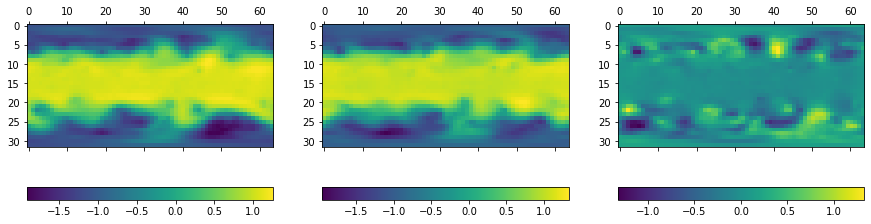

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
I = ax1.matshow(X[0, ..., 2])
fig.colorbar(I, ax=ax1, orientation='horizontal');
I = ax2.matshow(y[0, ..., 0])
fig.colorbar(I, ax=ax2, orientation='horizontal');
I = ax3.matshow(y[0, ..., 0]-X[0, ..., 2])
fig.colorbar(I, ax=ax3, orientation='horizontal');

In [24]:
dg = DataGenerator(ds_train, args['var_dict'], 72, shuffle=False, output_vars=args['output_vars'],
                   predict_difference=True)

In [77]:
X, y = dg[0]

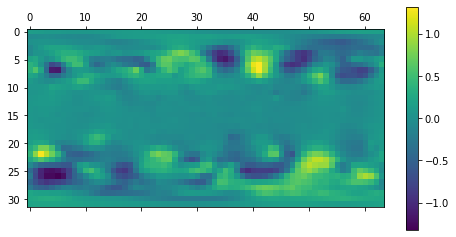

In [78]:
plt.matshow(y[0, ..., 0])
plt.colorbar();

Seems to work! Started test run 027

## Categorical

In [63]:
lead_time=72
d = dg.data.isel(level=dg.output_idxs).values
diff = d[lead_time:] - d[:-lead_time]

In [64]:
diff.shape

(1344, 32, 64, 2)

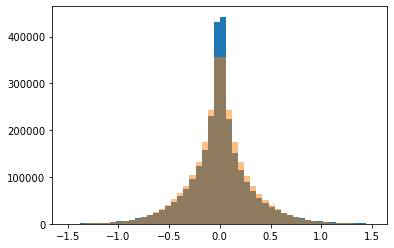

In [65]:
plt.hist(diff[..., 0].flat, bins=np.linspace(-1.5, 1.5, 51))
plt.hist(diff[..., 1].flat, alpha=0.5,bins= np.linspace(-1.5, 1.5, 51));

In [66]:
np.diff(np.linspace(-1.5, 1.5, 50))[0]

0.061224489795918435

In [67]:
dg.std[12].values * 0.061224489795918435

0.9262601905529565

In [69]:
bins = np.linspace(-1.5, 1.5, 51)
bins[0] = -np.inf; bins[-1] = np.inf

In [72]:
import pandas as pd

In [83]:
y_shape=y.shape
y_cat=pd.cut(y.reshape(-1), bins, labels=False).reshape(y_shape)
y_cat=tf.keras.utils.to_categorical(y_cat, num_classes=50)

In [86]:
y[1, 8, 0, 0], y_cat[1, 8, 0, 0]

(0.23679571,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [76]:
y.shape

(32, 32, 64, 2, 50)

In [89]:
dg = DataGenerator(ds_train, args['var_dict'], 72, shuffle=False, output_vars=args['output_vars'],
                   predict_difference=True, is_categorical=True, bin_min=-1.5, bin_max=1.5, num_bins=50)

In [90]:
X, y = dg[0]

In [91]:
y.shape

(32, 32, 64, 2, 50)

In [94]:
y[1, 8, 0, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

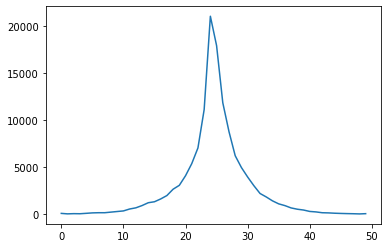

In [96]:
plt.plot(y.sum((0, 1, 2, 3)))

So this works as well.

## Model for categorical

In [97]:
from src.networks import *

In [103]:
model = build_resnet([128, 128, 128, 100], [7, 3, 3, 3], dg.shape, categorical=True, nvars=len(dg.output_idxs))

In [104]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 64, 38)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d_12 (PeriodicCon (None, 32, 64, 128)  238464      input_3[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 64, 128)  0           periodic_conv2d_12[0][0]         
__________________________________________________________________________________________________
periodic_conv2d_13 (PeriodicCon (None, 32, 64, 128)  147584      activation_11[0][0]              
____________________________________________________________________________________________

In [117]:
def create_lat_categorical_loss(lat, nvars):
    weights_lat = np.cos(np.deg2rad(lat)).values
    weights_lat /= weights_lat.mean()

    def categorical_loss(y_true, y_pred):    
        cce = tf.keras.losses.categorical_crossentropy
        loss = 0 #is this ok?
        for i in range(nvars):
            loss += cce(y_true[:,:,:,i,:], y_pred[:,:,:,i,:])*weights_lat[None, :, None]
        return loss    
    return categorical_loss

In [118]:
cat_loss = create_lat_categorical_loss(dg.data.lat, nvars=len(dg.output_idxs))

In [119]:
p = model(X)

In [108]:
p.shape

TensorShape([32, 32, 64, 2, 50])

In [122]:
p.numpy()[0, 0, 0, 0].sum()

0.9999695

In [110]:
y.shape

(32, 32, 64, 2, 50)

In [120]:
l = cat_loss(y, p)

In [121]:
l.shape

TensorShape([32, 32, 64])

In [123]:
model.compile('adam', cat_loss)

In [125]:
model.fit(dg, epochs=100)

Epoch 1/100
42/42 [==============================] - 2s 49ms/step - loss: 2.6266
Epoch 2/100
42/42 [==============================] - 2s 56ms/step - loss: 2.6411
Epoch 3/100
42/42 [==============================] - 2s 54ms/step - loss: 2.6768
Epoch 4/100
42/42 [==============================] - 2s 52ms/step - loss: 2.6966
Epoch 5/100
42/42 [==============================] - 2s 55ms/step - loss: 2.7050
Epoch 6/100
42/42 [==============================] - 2s 57ms/step - loss: 2.6294
Epoch 7/100
42/42 [==============================] - 2s 54ms/step - loss: 2.5907
Epoch 8/100
42/42 [==============================] - 2s 57ms/step - loss: 2.5940
Epoch 9/100
42/42 [==============================] - 2s 50ms/step - loss: 2.5807
Epoch 10/100
42/42 [==============================] - 2s 48ms/step - loss: 2.5578
Epoch 11/100
42/42 [==============================] - 2s 48ms/step - loss: 2.6401
Epoch 12/100
42/42 [==============================] - 2s 48ms/step - loss: 2.6767
Epoch 13/100
42/42 [=====

In [129]:
p = model.predict(X)

In [130]:
p.shape

(32, 32, 64, 2, 50)

<BarContainer object of 50 artists>

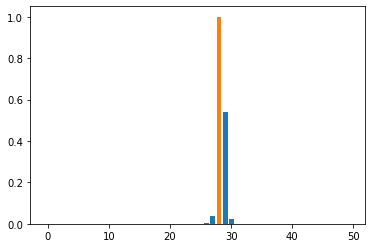

In [133]:
plt.bar(np.arange(50), p[0, 8, 0, 0])
plt.bar(np.arange(50), y[0, 8, 0, 0])

Seems to work somewhat, let's test it with the full data.

## Load trained model

In [8]:
args = load_args('../nn_configs/C/028-resnet_d3_ztt_3d_cat.yml')

In [9]:
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [10]:
dg_test = load_data(**args, only_test=True)

In [11]:
model = load_model(args)

In [12]:
X, y = dg_test[0]

In [13]:
truth = []
preds = []
for X, y in dg_test:
    truth.append(y)
    preds.append(model.predict(X))

In [14]:
truth = np.concatenate(truth)
preds = np.concatenate(preds)

In [15]:
preds.shape, truth.shape

((8718, 32, 64, 2, 50), (8718, 32, 64, 2, 50))

<BarContainer object of 50 artists>

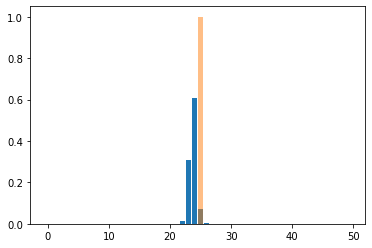

In [21]:
plt.bar(np.arange(50), preds[0, 16, 20, 1])
plt.bar(np.arange(50), y[0, 16, 20, 1], alpha=0.5)

In [22]:
dg_test.bins

array([ -inf, -1.44, -1.38, -1.32, -1.26, -1.2 , -1.14, -1.08, -1.02,
       -0.96, -0.9 , -0.84, -0.78, -0.72, -0.66, -0.6 , -0.54, -0.48,
       -0.42, -0.36, -0.3 , -0.24, -0.18, -0.12, -0.06,  0.  ,  0.06,
        0.12,  0.18,  0.24,  0.3 ,  0.36,  0.42,  0.48,  0.54,  0.6 ,
        0.66,  0.72,  0.78,  0.84,  0.9 ,  0.96,  1.02,  1.08,  1.14,
        1.2 ,  1.26,  1.32,  1.38,  1.44,   inf])

In [27]:
dim_bin = dg_test.bins[:, None] * dg_test.std.isel(level=dg_test.output_idxs).values
dim_bin.shape

(51, 2)

In [28]:
dim_bin[:, 0]

array([          -inf, -4847.98877242, -4645.98924024, -4443.98970805,
       -4241.99017587, -4039.99064368, -3837.9911115 , -3635.99157932,
       -3433.99204713, -3231.99251495, -3029.99298276, -2827.99345058,
       -2625.99391839, -2423.99438621, -2221.99485403, -2019.99532184,
       -1817.99578966, -1615.99625747, -1413.99672529, -1211.99719311,
       -1009.99766092,  -807.99812874,  -605.99859655,  -403.99906437,
        -201.99953218,     0.        ,   201.99953218,   403.99906437,
         605.99859655,   807.99812874,  1009.99766092,  1211.99719311,
        1413.99672529,  1615.99625747,  1817.99578966,  2019.99532184,
        2221.99485403,  2423.99438621,  2625.99391839,  2827.99345058,
        3029.99298276,  3231.99251495,  3433.99204713,  3635.99157932,
        3837.9911115 ,  4039.99064368,  4241.99017587,  4443.98970805,
        4645.98924024,  4847.98877242,            inf])

In [32]:
dg_test.valid_time

<xarray.DataArray 'time' (time: 8718)>
array(['2017-01-04T12:00:00.000000000', '2017-01-04T14:00:00.000000000',
       '2017-01-04T16:00:00.000000000', ..., '2018-12-31T18:00:00.000000000',
       '2018-12-31T20:00:00.000000000', '2018-12-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T22:00:00
Attributes:
    long_name:  time

In [31]:
valdir = '/data/stephan/WeatherBench/5.625deg/'
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid]).load()

In [111]:
aa = valid.z.sel(time='2017-01-04T00') - valid.z.sel(time='2017-01-01T00')

In [45]:
valid_diff = (valid.shift() - valid.shift(time=72)).dropna('time')

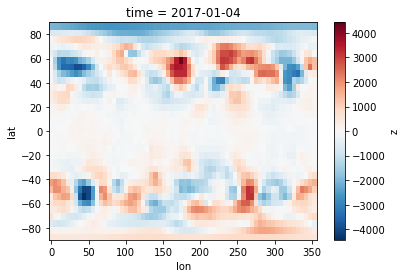

In [46]:
valid_diff.z.isel(time=0).plot()

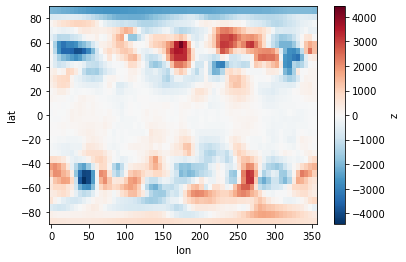

In [112]:
aa.plot()

In [72]:
dim_bin[0, 0] = valid_diff.z.min().values
dim_bin[-1, 0] = valid_diff.z.max().values
dim_bin[0, 1] = valid_diff.t.min().values
dim_bin[-1, 1] = valid_diff.t.max().values

In [47]:
preds.shape

(8718, 32, 64, 2, 50)

In [49]:
preds = xr.merge([xr.DataArray(
    preds[:, :, :, 0],
    dims=['time', 'lat', 'lon', 'bins'],
    coords={'time': dg_test.valid_time, 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
            'bins': np.arange(50)},
    name='z'
),
xr.DataArray(
    preds[:, :, :, 1],
    dims=['time', 'lat', 'lon', 'bins'],
    coords={'time': dg_test.valid_time, 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
            'bins': np.arange(50)},
    name='t'
)])

In [70]:
valid_diff.max(), valid_diff.min()

(<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 8.078e+03
     t        float64 36.17,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 -7.297e+03
     t        float64 -40.81)

In [97]:
dim_bin[2] - dim_bin[1]

array([201.99953218,   0.94937677])

In [72]:
dim_bin[0, 0] = valid_diff.z.min().values
dim_bin[-1, 0] = valid_diff.z.max().values
dim_bin[0, 1] = valid_diff.t.min().values
dim_bin[-1, 1] = valid_diff.t.max().values

In [102]:
dim_bin[0, 0] = dim_bin[1, 0] - 201.99953218
dim_bin[-1, 0] = dim_bin[-2, 0] + 201.99953218
dim_bin[0, 1] = dim_bin[1, 1] - 0.94937677
dim_bin[-1, 1] = dim_bin[-2, 1] + 0.94937677

In [103]:
dim_bin

array([[-5.04998830e+03, -2.37344192e+01],
       [-4.84798877e+03, -2.27850424e+01],
       [-4.64598924e+03, -2.18356657e+01],
       [-4.44398971e+03, -2.08862889e+01],
       [-4.24199018e+03, -1.99369121e+01],
       [-4.03999064e+03, -1.89875354e+01],
       [-3.83799111e+03, -1.80381586e+01],
       [-3.63599158e+03, -1.70887818e+01],
       [-3.43399205e+03, -1.61394051e+01],
       [-3.23199251e+03, -1.51900283e+01],
       [-3.02999298e+03, -1.42406515e+01],
       [-2.82799345e+03, -1.32912748e+01],
       [-2.62599392e+03, -1.23418980e+01],
       [-2.42399439e+03, -1.13925212e+01],
       [-2.22199485e+03, -1.04431444e+01],
       [-2.01999532e+03, -9.49376768e+00],
       [-1.81799579e+03, -8.54439091e+00],
       [-1.61599626e+03, -7.59501414e+00],
       [-1.41399673e+03, -6.64563738e+00],
       [-1.21199719e+03, -5.69626061e+00],
       [-1.00999766e+03, -4.74688384e+00],
       [-8.07998129e+02, -3.79750707e+00],
       [-6.05998597e+02, -2.84813030e+00],
       [-4.

In [104]:
preds.z.attrs['bin_edges'] = dim_bin[:, 0]
preds.t.attrs['bin_edges'] = dim_bin[:, 1]

In [206]:
def compute_bin_crps(obs, preds, bin_edges):
    """
    Last axis must be bin axis
    obs: [...]
    preds: [..., n_bins]
    """
#     pdb.set_trace()
    obs = obs.values
    preds = preds.values

    # Convert observation
    a = np.minimum(bin_edges[1:], obs[..., None])
#     b = bin_edges[:-1] * (bin_edges[0:-1] > obs[..., None])
    b = np.where(bin_edges[:-1] > obs[..., None], bin_edges[:-1],  -np.inf)
    y = np.maximum(a, b)
#     print('a =', a)
#     print('b =', b)
#     print('y =', y)
    # Convert predictions to cumulative predictions with a zero at the beginning
    cum_preds = np.cumsum(preds, -1)
    cum_preds_zero = np.concatenate([np.zeros((*cum_preds.shape[:-1], 1)), cum_preds], -1)
    xmin = bin_edges[..., :-1]
    xmax = bin_edges[..., 1:]
    lmass = cum_preds_zero[..., :-1]
    umass = 1 - cum_preds_zero[..., 1:]
#     y = np.atleast_1d(y)
#     xmin, xmax = np.atleast_1d(xmin), np.atleast_1d(xmax)
#     lmass, lmass = np.atleast_1d(lmass), np.atleast_1d(lmass)
    scale = xmax - xmin
#     print('scale =', scale)
    y_scale = (y - xmin) / scale
#     print('y_scale = ', y_scale)
    
    z = y_scale.copy()
    z[z < 0] = 0
    z[z > 1] = 1
#     print('z =', z)
    a = 1 - (lmass + umass)
#     print('a =', a)
    crps = (
        np.abs(y_scale - z) + z**2 * a - z * (1 - 2*lmass) + 
        a**2 / 3 + (1 - lmass) * umass
    )
    return np.sum(scale * crps, -1)

In [221]:
def compute_bin_crps_da(da_true, da_fc, batch=100):
    n = int(np.ceil(len(da_fc.time) / batch))
    result = []
    for i in tqdm(range(n)):
        sl = slice(i*batch, (i+1)*batch)
        r = compute_bin_crps(da_true.isel(time=sl), da_fc.isel(time=sl), da_fc.bin_edges)
        result.append(r)
    return np.concatenate(result)
    
def compute_weighted_bin_crps(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    """
    t = np.intersect1d(da_fc.time, da_true.time)
    da_fc, da_true = da_fc.sel(time=t), da_true.sel(time=t)
    weights_lat = np.cos(np.deg2rad(da_true.lat))
    weights_lat /= weights_lat.mean()
    dims = ['time', 'lat', 'lon']
    if type(da_true) is xr.Dataset:
        das = []
        for var in da_true:
            result = compute_bin_crps_da(da_true[var], da_fc[var])
#             result = compute_bin_crps(da_true[var], da_fc[var], da_fc[var].bin_edges)
            das.append(xr.DataArray(
                result, dims=dims, coords=dict(da_true.coords), name=var
            ))
        crps = xr.merge(das)
    else:
#         result = compute_bin_crps(da_true, da_fc, da_fc.bin_edges)
        result = compute_bin_crps_da(da_true, da_fc)
        crps = xr.DataArray(
            result, dims=dims, coords=dict(da_true.coords), name=da_fc.name
        )
    crps = (crps * weights_lat).mean(mean_dims)
    return crps

In [222]:
%time compute_weighted_bin_crps(preds.isel(time=slice(0, 10)), valid_diff)


CPU times: user 165 ms, sys: 14.9 ms, total: 179 ms
Wall time: 410 ms


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 151.6
    t        float64 0.9605

In [224]:
%time compute_weighted_bin_crps(preds, valid_diff.isel(time=slice(0, None, 12)))


CPU times: user 15.8 s, sys: 196 ms, total: 16 s
Wall time: 16 s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 140.4
    t        float64 0.9133

Parametric: 134.503, 0.877 

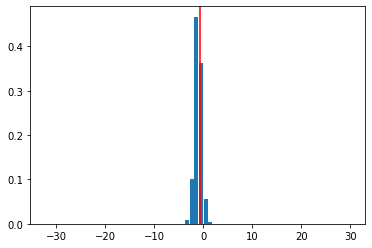

In [92]:
plt.bar(a, preds.t.sel(time='2017-01-04T12').isel(lat=16, lon=0).values)
plt.axvline(valid_diff.t.sel(time='2017-01-04T12').isel(lat=16, lon=0), c='r')

In [30]:
np.save('/home/rasp/data/myWeatherBench/predictions_C/028_cat.npy', preds)
np.save('/home/rasp/data/myWeatherBench/predictions_C/028_cat_truth.npy', truth)